## Setting up
- Notebook: `RMSprop(model.parameters(), lr=0.01, alpha=0.99)` 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/oml-project

/content/drive/My Drive/Data Colab/oml-project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

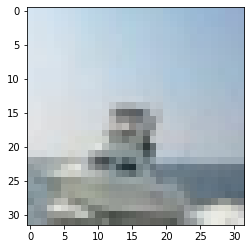

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Performace at epoch 1
Train Loss: 30.27067 ; Train Acc: 0.20996
Test Loss: 2.01282 ; Test Acc: 0.25105


100%|██████████| 391/391 [00:06<00:00, 59.07it/s]


Performace at epoch 2
Train Loss: 1.93180 ; Train Acc: 0.28932
Test Loss: 1.87885 ; Test Acc: 0.29610


100%|██████████| 391/391 [00:06<00:00, 58.49it/s]


Performace at epoch 3
Train Loss: 1.91078 ; Train Acc: 0.30880
Test Loss: 2.32329 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.57it/s]


Performace at epoch 4
Train Loss: 2.30473 ; Train Acc: 0.10356
Test Loss: 2.30317 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.59it/s]


Performace at epoch 5
Train Loss: 2.30370 ; Train Acc: 0.09880
Test Loss: 2.30446 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.33it/s]


Performace at epoch 6
Train Loss: 2.30401 ; Train Acc: 0.09568
Test Loss: 2.30306 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.23it/s]


Performace at epoch 7
Train Loss: 2.30361 ; Train Acc: 0.09836
Test Loss: 2.30369 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.05it/s]


Performace at epoch 8
Train Loss: 2.30379 ; Train Acc: 0.09596
Test Loss: 2.30371 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.79it/s]


Performace at epoch 9
Train Loss: 2.30362 ; Train Acc: 0.09960
Test Loss: 2.30308 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 10
Train Loss: 2.30373 ; Train Acc: 0.09744
Test Loss: 2.30313 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:07<00:00, 55.47it/s]


Performace at epoch 11
Train Loss: 2.30393 ; Train Acc: 0.09552
Test Loss: 2.30300 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:07<00:00, 55.85it/s]


Performace at epoch 12
Train Loss: 2.30359 ; Train Acc: 0.10008
Test Loss: 2.30348 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 13
Train Loss: 2.30377 ; Train Acc: 0.09996
Test Loss: 2.30350 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.23it/s]


Performace at epoch 14
Train Loss: 2.30380 ; Train Acc: 0.09956
Test Loss: 2.30332 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.56it/s]


Performace at epoch 15
Train Loss: 2.30381 ; Train Acc: 0.09644
Test Loss: 2.30301 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:07<00:00, 54.97it/s]


Performace at epoch 16
Train Loss: 2.30371 ; Train Acc: 0.09868
Test Loss: 2.30317 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.02it/s]


Performace at epoch 17
Train Loss: 2.30354 ; Train Acc: 0.09824
Test Loss: 2.30397 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.28it/s]


Performace at epoch 18
Train Loss: 2.30349 ; Train Acc: 0.10184
Test Loss: 2.30419 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.07it/s]


Performace at epoch 19
Train Loss: 2.30363 ; Train Acc: 0.09756
Test Loss: 2.30375 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Performace at epoch 20
Train Loss: 2.30377 ; Train Acc: 0.09888
Test Loss: 2.30270 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.53it/s]


Performace at epoch 21
Train Loss: 2.30357 ; Train Acc: 0.09772
Test Loss: 2.30321 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.22it/s]


Performace at epoch 22
Train Loss: 2.30375 ; Train Acc: 0.10012
Test Loss: 2.30381 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.68it/s]


Performace at epoch 23
Train Loss: 2.30376 ; Train Acc: 0.09796
Test Loss: 2.30341 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.57it/s]


Performace at epoch 24
Train Loss: 2.30355 ; Train Acc: 0.10160
Test Loss: 2.30322 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.05it/s]


Performace at epoch 25
Train Loss: 2.30392 ; Train Acc: 0.09692
Test Loss: 2.30323 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.10it/s]


Performace at epoch 26
Train Loss: 2.30380 ; Train Acc: 0.10004
Test Loss: 2.30326 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.71it/s]


Performace at epoch 27
Train Loss: 2.30356 ; Train Acc: 0.10212
Test Loss: 2.30357 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.23it/s]


Performace at epoch 28
Train Loss: 2.30366 ; Train Acc: 0.10020
Test Loss: 2.30325 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.51it/s]


Performace at epoch 29
Train Loss: 2.30399 ; Train Acc: 0.09560
Test Loss: 2.30318 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.07it/s]


Performace at epoch 30
Train Loss: 2.30381 ; Train Acc: 0.09692
Test Loss: 2.30315 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.73it/s]


Performace at epoch 31
Train Loss: 2.30364 ; Train Acc: 0.09992
Test Loss: 2.30290 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.54it/s]


Performace at epoch 32
Train Loss: 2.30356 ; Train Acc: 0.09620
Test Loss: 2.30383 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.08it/s]


Performace at epoch 33
Train Loss: 2.30386 ; Train Acc: 0.09500
Test Loss: 2.30303 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.74it/s]


Performace at epoch 34
Train Loss: 2.30385 ; Train Acc: 0.09856
Test Loss: 2.30322 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.69it/s]


Performace at epoch 35
Train Loss: 2.30378 ; Train Acc: 0.09892
Test Loss: 2.30333 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.48it/s]


Performace at epoch 36
Train Loss: 2.30367 ; Train Acc: 0.10012
Test Loss: 2.30384 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.24it/s]


Performace at epoch 37
Train Loss: 2.30361 ; Train Acc: 0.09936
Test Loss: 2.30378 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 59.08it/s]


Performace at epoch 38
Train Loss: 2.30356 ; Train Acc: 0.10140
Test Loss: 2.30344 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.05it/s]


Performace at epoch 39
Train Loss: 2.30370 ; Train Acc: 0.09836
Test Loss: 2.30289 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.68it/s]


Performace at epoch 40
Train Loss: 2.30371 ; Train Acc: 0.09864
Test Loss: 2.30337 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.73it/s]


Performace at epoch 41
Train Loss: 2.30377 ; Train Acc: 0.09928
Test Loss: 2.30317 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.34it/s]


Performace at epoch 42
Train Loss: 2.30371 ; Train Acc: 0.09540
Test Loss: 2.30313 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.52it/s]


Performace at epoch 43
Train Loss: 2.30341 ; Train Acc: 0.09836
Test Loss: 2.30441 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.06it/s]


Performace at epoch 44
Train Loss: 2.30390 ; Train Acc: 0.09832
Test Loss: 2.30298 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Performace at epoch 45
Train Loss: 2.30364 ; Train Acc: 0.10108
Test Loss: 2.30348 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Performace at epoch 46
Train Loss: 2.30367 ; Train Acc: 0.09848
Test Loss: 2.30358 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.16it/s]


Performace at epoch 47
Train Loss: 2.30364 ; Train Acc: 0.09720
Test Loss: 2.30348 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.33it/s]


Performace at epoch 48
Train Loss: 2.30387 ; Train Acc: 0.09804
Test Loss: 2.30304 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.04it/s]


Performace at epoch 49
Train Loss: 2.30374 ; Train Acc: 0.09964
Test Loss: 2.30275 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.39it/s]


Performace at epoch 50
Train Loss: 2.30380 ; Train Acc: 0.09804
Test Loss: 2.30363 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.68it/s]


Performace at epoch 51
Train Loss: 2.30363 ; Train Acc: 0.09792
Test Loss: 2.30316 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.85it/s]


Performace at epoch 52
Train Loss: 2.30365 ; Train Acc: 0.10008
Test Loss: 2.30323 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Performace at epoch 53
Train Loss: 2.30363 ; Train Acc: 0.10088
Test Loss: 2.30370 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.82it/s]


Performace at epoch 54
Train Loss: 2.30357 ; Train Acc: 0.09840
Test Loss: 2.30391 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.43it/s]


Performace at epoch 55
Train Loss: 2.30359 ; Train Acc: 0.09976
Test Loss: 2.30313 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.95it/s]


Performace at epoch 56
Train Loss: 2.30345 ; Train Acc: 0.10004
Test Loss: 2.30446 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.50it/s]


Performace at epoch 57
Train Loss: 2.30390 ; Train Acc: 0.09660
Test Loss: 2.30312 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Performace at epoch 58
Train Loss: 2.30360 ; Train Acc: 0.09944
Test Loss: 2.30274 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.09it/s]


Performace at epoch 59
Train Loss: 2.30369 ; Train Acc: 0.09808
Test Loss: 2.30294 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.10it/s]


Performace at epoch 60
Train Loss: 2.30384 ; Train Acc: 0.09824
Test Loss: 2.30315 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.62it/s]


Performace at epoch 61
Train Loss: 2.30391 ; Train Acc: 0.09688
Test Loss: 2.30290 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.55it/s]


Performace at epoch 62
Train Loss: 2.30366 ; Train Acc: 0.09856
Test Loss: 2.30360 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.71it/s]


Performace at epoch 63
Train Loss: 2.30370 ; Train Acc: 0.09924
Test Loss: 2.30394 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.97it/s]


Performace at epoch 64
Train Loss: 2.30374 ; Train Acc: 0.09612
Test Loss: 2.30362 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.04it/s]


Performace at epoch 65
Train Loss: 2.30352 ; Train Acc: 0.10192
Test Loss: 2.30450 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.18it/s]


Performace at epoch 66
Train Loss: 2.30370 ; Train Acc: 0.09816
Test Loss: 2.30376 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.59it/s]


Performace at epoch 67
Train Loss: 2.30373 ; Train Acc: 0.09672
Test Loss: 2.30321 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Performace at epoch 68
Train Loss: 2.30381 ; Train Acc: 0.09604
Test Loss: 2.30351 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.52it/s]


Performace at epoch 69
Train Loss: 2.30376 ; Train Acc: 0.09872
Test Loss: 2.30397 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.23it/s]


Performace at epoch 70
Train Loss: 2.30374 ; Train Acc: 0.10012
Test Loss: 2.30302 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Performace at epoch 71
Train Loss: 2.30346 ; Train Acc: 0.10048
Test Loss: 2.30289 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.28it/s]


Performace at epoch 72
Train Loss: 2.30361 ; Train Acc: 0.09956
Test Loss: 2.30342 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.87it/s]


Performace at epoch 73
Train Loss: 2.30364 ; Train Acc: 0.09928
Test Loss: 2.30324 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.81it/s]


Performace at epoch 74
Train Loss: 2.30364 ; Train Acc: 0.10012
Test Loss: 2.30376 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Performace at epoch 75
Train Loss: 2.30345 ; Train Acc: 0.10192
Test Loss: 2.30307 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 55.91it/s]


Performace at epoch 76
Train Loss: 2.30360 ; Train Acc: 0.10100
Test Loss: 2.30351 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.97it/s]


Performace at epoch 77
Train Loss: 2.30377 ; Train Acc: 0.09544
Test Loss: 2.30322 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


Performace at epoch 78
Train Loss: 2.30341 ; Train Acc: 0.09932
Test Loss: 2.30319 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.94it/s]


Performace at epoch 79
Train Loss: 2.30357 ; Train Acc: 0.10184
Test Loss: 2.30347 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.58it/s]


Performace at epoch 80
Train Loss: 2.30373 ; Train Acc: 0.10124
Test Loss: 2.30323 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.82it/s]


Performace at epoch 81
Train Loss: 2.30354 ; Train Acc: 0.09736
Test Loss: 2.30423 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.77it/s]


Performace at epoch 82
Train Loss: 2.30379 ; Train Acc: 0.09952
Test Loss: 2.30351 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.58it/s]


Performace at epoch 83
Train Loss: 2.30369 ; Train Acc: 0.09940
Test Loss: 2.30292 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.09it/s]


Performace at epoch 84
Train Loss: 2.30363 ; Train Acc: 0.09992
Test Loss: 2.30355 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.14it/s]


Performace at epoch 85
Train Loss: 2.30390 ; Train Acc: 0.09864
Test Loss: 2.30326 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Performace at epoch 86
Train Loss: 2.30390 ; Train Acc: 0.09820
Test Loss: 2.30327 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.63it/s]


Performace at epoch 87
Train Loss: 2.30379 ; Train Acc: 0.09592
Test Loss: 2.30301 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.16it/s]


Performace at epoch 88
Train Loss: 2.30367 ; Train Acc: 0.10072
Test Loss: 2.30333 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.24it/s]


Performace at epoch 89
Train Loss: 2.30376 ; Train Acc: 0.09676
Test Loss: 2.30329 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.52it/s]


Performace at epoch 90
Train Loss: 2.30385 ; Train Acc: 0.09504
Test Loss: 2.30315 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.80it/s]


Performace at epoch 91
Train Loss: 2.30381 ; Train Acc: 0.09780
Test Loss: 2.30336 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.25it/s]


Performace at epoch 92
Train Loss: 2.30388 ; Train Acc: 0.09772
Test Loss: 2.30293 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:07<00:00, 55.24it/s]


Performace at epoch 93
Train Loss: 2.30398 ; Train Acc: 0.09488
Test Loss: 2.30298 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.22it/s]


Performace at epoch 94
Train Loss: 2.30372 ; Train Acc: 0.09936
Test Loss: 2.30360 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 58.93it/s]


Performace at epoch 95
Train Loss: 2.30364 ; Train Acc: 0.09932
Test Loss: 2.30285 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Performace at epoch 96
Train Loss: 2.30376 ; Train Acc: 0.09864
Test Loss: 2.30337 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.73it/s]


Performace at epoch 97
Train Loss: 2.30368 ; Train Acc: 0.10008
Test Loss: 2.30373 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.20it/s]


Performace at epoch 98
Train Loss: 2.30358 ; Train Acc: 0.09976
Test Loss: 2.30323 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 56.84it/s]


Performace at epoch 99
Train Loss: 2.30379 ; Train Acc: 0.09740
Test Loss: 2.30297 ; Test Acc: 0.10000


100%|██████████| 391/391 [00:06<00:00, 57.16it/s]


Performace at epoch 100
Train Loss: 2.30385 ; Train Acc: 0.09708
Test Loss: 2.30295 ; Test Acc: 0.10000


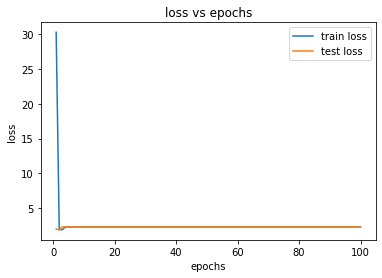

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

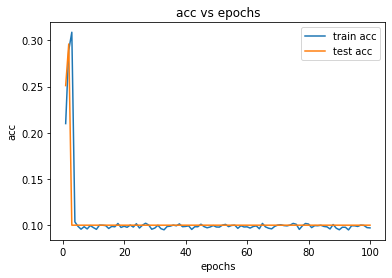

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001],
    'alpha': [0.9, 0.99, 0.999],
    'eps': [1e-7, 1e-8, 1e-9],
    'weight_decay': [1e-4, 1e-5, 1e-6]
}
TRIALS = 10

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = np.random.choice(HYPERPARAMS[h])
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=chosen['lr'], alpha=chosen['alpha'], eps=chosen['eps'], weight_decay=chosen['weight_decay'])
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.005, 'alpha': 0.99, 'eps': 1e-07, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 59.10it/s]


Training loss at epoch 1: 3.61928


100%|██████████| 391/391 [00:06<00:00, 56.99it/s]


Training loss at epoch 2: 1.54714


100%|██████████| 391/391 [00:06<00:00, 57.89it/s]


Training loss at epoch 3: 1.34346


100%|██████████| 391/391 [00:06<00:00, 57.37it/s]


Training loss at epoch 4: 1.22199


100%|██████████| 391/391 [00:06<00:00, 57.18it/s]


Training loss at epoch 5: 1.07018


100%|██████████| 391/391 [00:06<00:00, 57.75it/s]


Training loss at epoch 6: 0.93133


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Training loss at epoch 7: 0.80538


100%|██████████| 391/391 [00:06<00:00, 57.77it/s]


Training loss at epoch 8: 0.68120


100%|██████████| 391/391 [00:06<00:00, 58.74it/s]


Training loss at epoch 9: 0.58251


100%|██████████| 391/391 [00:06<00:00, 57.89it/s]


Training loss at epoch 10: 0.49699


100%|██████████| 391/391 [00:06<00:00, 56.99it/s]


Training loss at epoch 11: 0.43679


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Training loss at epoch 12: 0.37828


100%|██████████| 391/391 [00:06<00:00, 57.77it/s]


Training loss at epoch 13: 0.33866


100%|██████████| 391/391 [00:06<00:00, 58.10it/s]


Training loss at epoch 14: 0.30836


100%|██████████| 391/391 [00:06<00:00, 58.06it/s]


Training loss at epoch 15: 0.28884


100%|██████████| 391/391 [00:06<00:00, 56.73it/s]


Training loss at epoch 16: 0.27279


100%|██████████| 391/391 [00:06<00:00, 56.92it/s]


Training loss at epoch 17: 0.25232


100%|██████████| 391/391 [00:06<00:00, 57.55it/s]


Training loss at epoch 18: 0.23824


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Training loss at epoch 19: 0.22861


100%|██████████| 391/391 [00:06<00:00, 57.53it/s]


Training loss at epoch 20: 0.21769
* Testing loss: 3.24636

* Best params updated!: {'lr': 0.005, 'alpha': 0.99, 'eps': 1e-07, 'weight_decay': 1e-05}

> Starting trial 2
Chosen hyperparams: {'lr': 0.001, 'alpha': 0.999, 'eps': 1e-09, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 57.59it/s]


Training loss at epoch 1: 2.21244


100%|██████████| 391/391 [00:06<00:00, 56.98it/s]


Training loss at epoch 2: 1.39197


100%|██████████| 391/391 [00:06<00:00, 58.55it/s]


Training loss at epoch 3: 1.20280


100%|██████████| 391/391 [00:06<00:00, 58.42it/s]


Training loss at epoch 4: 1.06394


100%|██████████| 391/391 [00:06<00:00, 57.95it/s]


Training loss at epoch 5: 0.94214


100%|██████████| 391/391 [00:06<00:00, 57.57it/s]


Training loss at epoch 6: 0.82384


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Training loss at epoch 7: 0.71803


100%|██████████| 391/391 [00:06<00:00, 58.72it/s]


Training loss at epoch 8: 0.60077


100%|██████████| 391/391 [00:07<00:00, 55.44it/s]


Training loss at epoch 9: 0.49725


100%|██████████| 391/391 [00:06<00:00, 57.11it/s]


Training loss at epoch 10: 0.39765


100%|██████████| 391/391 [00:06<00:00, 56.76it/s]


Training loss at epoch 11: 0.30996


100%|██████████| 391/391 [00:06<00:00, 56.93it/s]


Training loss at epoch 12: 0.24010


100%|██████████| 391/391 [00:06<00:00, 58.56it/s]


Training loss at epoch 13: 0.16014


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Training loss at epoch 14: 0.13870


100%|██████████| 391/391 [00:06<00:00, 57.54it/s]


Training loss at epoch 15: 0.10153


100%|██████████| 391/391 [00:06<00:00, 57.65it/s]


Training loss at epoch 16: 0.06835


100%|██████████| 391/391 [00:06<00:00, 58.23it/s]


Training loss at epoch 17: 0.08040


100%|██████████| 391/391 [00:06<00:00, 57.66it/s]


Training loss at epoch 18: 0.16076


100%|██████████| 391/391 [00:06<00:00, 58.25it/s]


Training loss at epoch 19: 0.02610


100%|██████████| 391/391 [00:06<00:00, 58.38it/s]


Training loss at epoch 20: 0.04915
* Testing loss: 2.91909

* Best params updated!: {'lr': 0.001, 'alpha': 0.999, 'eps': 1e-09, 'weight_decay': 1e-06}

> Starting trial 3
Chosen hyperparams: {'lr': 0.0001, 'alpha': 0.9, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 58.64it/s]


Training loss at epoch 1: 1.94873


100%|██████████| 391/391 [00:06<00:00, 58.65it/s]


Training loss at epoch 2: 1.68533


100%|██████████| 391/391 [00:06<00:00, 57.93it/s]


Training loss at epoch 3: 1.56351


100%|██████████| 391/391 [00:06<00:00, 58.82it/s]


Training loss at epoch 4: 1.48225


100%|██████████| 391/391 [00:06<00:00, 58.39it/s]


Training loss at epoch 5: 1.42240


100%|██████████| 391/391 [00:06<00:00, 58.22it/s]


Training loss at epoch 6: 1.36958


100%|██████████| 391/391 [00:06<00:00, 58.75it/s]


Training loss at epoch 7: 1.32224


100%|██████████| 391/391 [00:06<00:00, 57.51it/s]


Training loss at epoch 8: 1.28051


100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Training loss at epoch 9: 1.24383


100%|██████████| 391/391 [00:06<00:00, 58.38it/s]


Training loss at epoch 10: 1.20981


100%|██████████| 391/391 [00:06<00:00, 57.27it/s]


Training loss at epoch 11: 1.18150


100%|██████████| 391/391 [00:06<00:00, 56.27it/s]


Training loss at epoch 12: 1.14954


100%|██████████| 391/391 [00:06<00:00, 56.53it/s]


Training loss at epoch 13: 1.12396


100%|██████████| 391/391 [00:06<00:00, 57.75it/s]


Training loss at epoch 14: 1.09615


100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Training loss at epoch 15: 1.07018


100%|██████████| 391/391 [00:07<00:00, 54.72it/s]


Training loss at epoch 16: 1.04529


100%|██████████| 391/391 [00:07<00:00, 54.74it/s]


Training loss at epoch 17: 1.01855


100%|██████████| 391/391 [00:06<00:00, 56.73it/s]


Training loss at epoch 18: 0.99550


100%|██████████| 391/391 [00:06<00:00, 56.97it/s]


Training loss at epoch 19: 0.96981


100%|██████████| 391/391 [00:06<00:00, 57.47it/s]


Training loss at epoch 20: 0.94874


100%|██████████| 391/391 [00:06<00:00, 58.08it/s]


Training loss at epoch 21: 0.92380


100%|██████████| 391/391 [00:06<00:00, 58.14it/s]


Training loss at epoch 22: 0.90017


100%|██████████| 391/391 [00:06<00:00, 57.71it/s]


Training loss at epoch 23: 0.87749


100%|██████████| 391/391 [00:06<00:00, 56.86it/s]


Training loss at epoch 24: 0.85433


100%|██████████| 391/391 [00:06<00:00, 56.36it/s]


Training loss at epoch 25: 0.83023
* Testing loss: 1.17216

* Best params updated!: {'lr': 0.0001, 'alpha': 0.9, 'eps': 1e-07, 'weight_decay': 1e-06}

> Starting trial 4
Chosen hyperparams: {'lr': 0.05, 'alpha': 0.99, 'eps': 1e-07, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 56.48it/s]


Training loss at epoch 1: 23448.63970


100%|██████████| 391/391 [00:07<00:00, 54.39it/s]


Training loss at epoch 2: 2.42435


100%|██████████| 391/391 [00:07<00:00, 54.99it/s]


Training loss at epoch 3: 3.10791


100%|██████████| 391/391 [00:07<00:00, 54.83it/s]


Training loss at epoch 4: 2.31374


100%|██████████| 391/391 [00:06<00:00, 56.11it/s]


Training loss at epoch 5: 3.77943


100%|██████████| 391/391 [00:06<00:00, 57.55it/s]


Training loss at epoch 6: 2.31228


100%|██████████| 391/391 [00:07<00:00, 55.78it/s]


Training loss at epoch 7: 2.31167


100%|██████████| 391/391 [00:06<00:00, 56.12it/s]


Training loss at epoch 8: 2.37446


100%|██████████| 391/391 [00:06<00:00, 56.64it/s]


Training loss at epoch 9: 2.30816


100%|██████████| 391/391 [00:06<00:00, 57.90it/s]


Training loss at epoch 10: 2.30760


100%|██████████| 391/391 [00:06<00:00, 58.34it/s]


Training loss at epoch 11: 3.07560


100%|██████████| 391/391 [00:06<00:00, 59.36it/s]


Training loss at epoch 12: 2.31021


100%|██████████| 391/391 [00:06<00:00, 59.00it/s]


Training loss at epoch 13: 2.30818


100%|██████████| 391/391 [00:06<00:00, 58.99it/s]


Training loss at epoch 14: 2.30673


100%|██████████| 391/391 [00:06<00:00, 57.70it/s]


Training loss at epoch 15: 2.30786
* Testing loss: 2.30743

> Starting trial 5
Chosen hyperparams: {'lr': 0.01, 'alpha': 0.99, 'eps': 1e-09, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 57.55it/s]


Training loss at epoch 1: 53.80359


100%|██████████| 391/391 [00:06<00:00, 58.35it/s]


Training loss at epoch 2: 2.18661


100%|██████████| 391/391 [00:06<00:00, 56.18it/s]


Training loss at epoch 3: 1.88120


100%|██████████| 391/391 [00:06<00:00, 56.84it/s]


Training loss at epoch 4: 1.72371


100%|██████████| 391/391 [00:06<00:00, 57.20it/s]


Training loss at epoch 5: 1.61523


100%|██████████| 391/391 [00:06<00:00, 57.44it/s]


Training loss at epoch 6: 1.54672


100%|██████████| 391/391 [00:06<00:00, 56.96it/s]


Training loss at epoch 7: 1.49642


100%|██████████| 391/391 [00:06<00:00, 57.03it/s]


Training loss at epoch 8: 1.43204


100%|██████████| 391/391 [00:06<00:00, 56.18it/s]


Training loss at epoch 9: 1.66871


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Training loss at epoch 10: 3.82865


100%|██████████| 391/391 [00:06<00:00, 56.30it/s]


Training loss at epoch 11: 2.40374


100%|██████████| 391/391 [00:07<00:00, 55.71it/s]


Training loss at epoch 12: 1.43461


100%|██████████| 391/391 [00:07<00:00, 55.66it/s]


Training loss at epoch 13: 1.35600


100%|██████████| 391/391 [00:06<00:00, 57.10it/s]


Training loss at epoch 14: 1.33408


100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Training loss at epoch 15: 1.27418
* Testing loss: 1.62534

> Starting trial 6
Chosen hyperparams: {'lr': 0.0001, 'alpha': 0.999, 'eps': 1e-08, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Training loss at epoch 1: 1.82667


100%|██████████| 391/391 [00:06<00:00, 57.53it/s]


Training loss at epoch 2: 1.57868


100%|██████████| 391/391 [00:06<00:00, 57.08it/s]


Training loss at epoch 3: 1.49190


100%|██████████| 391/391 [00:06<00:00, 55.91it/s]


Training loss at epoch 4: 1.42748


100%|██████████| 391/391 [00:06<00:00, 56.34it/s]


Training loss at epoch 5: 1.37424


100%|██████████| 391/391 [00:06<00:00, 55.99it/s]


Training loss at epoch 6: 1.32769


100%|██████████| 391/391 [00:06<00:00, 56.09it/s]


Training loss at epoch 7: 1.28666


100%|██████████| 391/391 [00:06<00:00, 57.22it/s]


Training loss at epoch 8: 1.25199


100%|██████████| 391/391 [00:06<00:00, 56.82it/s]


Training loss at epoch 9: 1.21885


100%|██████████| 391/391 [00:06<00:00, 57.49it/s]


Training loss at epoch 10: 1.18833


100%|██████████| 391/391 [00:06<00:00, 59.24it/s]


Training loss at epoch 11: 1.16254


100%|██████████| 391/391 [00:06<00:00, 58.65it/s]


Training loss at epoch 12: 1.13559


100%|██████████| 391/391 [00:06<00:00, 59.51it/s]


Training loss at epoch 13: 1.11309


100%|██████████| 391/391 [00:06<00:00, 58.28it/s]


Training loss at epoch 14: 1.08790


100%|██████████| 391/391 [00:06<00:00, 57.68it/s]


Training loss at epoch 15: 1.06651


100%|██████████| 391/391 [00:06<00:00, 57.26it/s]


Training loss at epoch 16: 1.04525


100%|██████████| 391/391 [00:06<00:00, 57.42it/s]


Training loss at epoch 17: 1.02503


100%|██████████| 391/391 [00:06<00:00, 57.43it/s]


Training loss at epoch 18: 1.00604


100%|██████████| 391/391 [00:06<00:00, 57.14it/s]


Training loss at epoch 19: 0.98694


100%|██████████| 391/391 [00:06<00:00, 57.79it/s]


Training loss at epoch 20: 0.96547


100%|██████████| 391/391 [00:06<00:00, 58.03it/s]


Training loss at epoch 21: 0.94813


100%|██████████| 391/391 [00:06<00:00, 58.30it/s]


Training loss at epoch 22: 0.93207


100%|██████████| 391/391 [00:06<00:00, 56.60it/s]


Training loss at epoch 23: 0.90979


100%|██████████| 391/391 [00:06<00:00, 57.81it/s]


Training loss at epoch 24: 0.89220


100%|██████████| 391/391 [00:06<00:00, 56.27it/s]


Training loss at epoch 25: 0.87627
* Testing loss: 1.11949

* Best params updated!: {'lr': 0.0001, 'alpha': 0.999, 'eps': 1e-08, 'weight_decay': 1e-06}

> Starting trial 7
Chosen hyperparams: {'lr': 0.001, 'alpha': 0.999, 'eps': 1e-09, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Training loss at epoch 1: 3.00385


100%|██████████| 391/391 [00:06<00:00, 56.95it/s]


Training loss at epoch 2: 1.53995


100%|██████████| 391/391 [00:06<00:00, 56.79it/s]


Training loss at epoch 3: 1.34854


100%|██████████| 391/391 [00:06<00:00, 56.30it/s]


Training loss at epoch 4: 1.22412


100%|██████████| 391/391 [00:06<00:00, 56.97it/s]


Training loss at epoch 5: 1.11942


100%|██████████| 391/391 [00:06<00:00, 56.50it/s]


Training loss at epoch 6: 1.03009


100%|██████████| 391/391 [00:06<00:00, 56.04it/s]


Training loss at epoch 7: 0.94357


100%|██████████| 391/391 [00:07<00:00, 55.82it/s]


Training loss at epoch 8: 0.85895


100%|██████████| 391/391 [00:06<00:00, 56.30it/s]


Training loss at epoch 9: 0.77726


100%|██████████| 391/391 [00:06<00:00, 55.96it/s]


Training loss at epoch 10: 0.69472


100%|██████████| 391/391 [00:06<00:00, 57.42it/s]


Training loss at epoch 11: 0.61771


100%|██████████| 391/391 [00:06<00:00, 57.13it/s]


Training loss at epoch 12: 0.52835


100%|██████████| 391/391 [00:06<00:00, 57.07it/s]


Training loss at epoch 13: 0.44803


100%|██████████| 391/391 [00:06<00:00, 56.94it/s]


Training loss at epoch 14: 0.37366


100%|██████████| 391/391 [00:06<00:00, 56.38it/s]


Training loss at epoch 15: 0.30825


100%|██████████| 391/391 [00:06<00:00, 57.18it/s]


Training loss at epoch 16: 0.24186


100%|██████████| 391/391 [00:06<00:00, 56.91it/s]


Training loss at epoch 17: 0.19760


100%|██████████| 391/391 [00:06<00:00, 56.34it/s]


Training loss at epoch 18: 0.16027


100%|██████████| 391/391 [00:06<00:00, 57.55it/s]


Training loss at epoch 19: 0.11233


100%|██████████| 391/391 [00:06<00:00, 57.21it/s]


Training loss at epoch 20: 0.12757
* Testing loss: 2.73554

> Starting trial 8
Chosen hyperparams: {'lr': 0.1, 'alpha': 0.999, 'eps': 1e-09, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Training loss at epoch 1: 23651645.03499


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Training loss at epoch 2: 2.31422


100%|██████████| 391/391 [00:06<00:00, 56.70it/s]


Training loss at epoch 3: 2.31214


100%|██████████| 391/391 [00:06<00:00, 57.30it/s]


Training loss at epoch 4: 5.24244


100%|██████████| 391/391 [00:06<00:00, 56.85it/s]


Training loss at epoch 5: 2.33488


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Training loss at epoch 6: 2.31445


100%|██████████| 391/391 [00:07<00:00, 55.56it/s]


Training loss at epoch 7: 2.31135


100%|██████████| 391/391 [00:06<00:00, 57.03it/s]


Training loss at epoch 8: 2.33861


100%|██████████| 391/391 [00:06<00:00, 56.60it/s]


Training loss at epoch 9: 2.31571


100%|██████████| 391/391 [00:06<00:00, 58.28it/s]


Training loss at epoch 10: 2.71086
* Testing loss: 2.31030

> Starting trial 9
Chosen hyperparams: {'lr': 0.05, 'alpha': 0.99, 'eps': 1e-08, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 57.24it/s]


Training loss at epoch 1: 10791.48919


100%|██████████| 391/391 [00:06<00:00, 56.93it/s]


Training loss at epoch 2: 10.18817


100%|██████████| 391/391 [00:06<00:00, 56.45it/s]


Training loss at epoch 3: 2.32314


100%|██████████| 391/391 [00:06<00:00, 56.61it/s]


Training loss at epoch 4: 2.31936


100%|██████████| 391/391 [00:06<00:00, 56.18it/s]


Training loss at epoch 5: 2.36033


100%|██████████| 391/391 [00:07<00:00, 55.40it/s]


Training loss at epoch 6: 2.33082


100%|██████████| 391/391 [00:07<00:00, 55.35it/s]


Training loss at epoch 7: 2.37360


100%|██████████| 391/391 [00:07<00:00, 55.30it/s]


Training loss at epoch 8: 2.31110


100%|██████████| 391/391 [00:07<00:00, 55.61it/s]


Training loss at epoch 9: 2.30728


100%|██████████| 391/391 [00:07<00:00, 55.09it/s]


Training loss at epoch 10: 2.30748


100%|██████████| 391/391 [00:07<00:00, 55.47it/s]


Training loss at epoch 11: 2.30749


100%|██████████| 391/391 [00:06<00:00, 56.46it/s]


Training loss at epoch 12: 2.30736


100%|██████████| 391/391 [00:06<00:00, 57.50it/s]


Training loss at epoch 13: 2.30785


100%|██████████| 391/391 [00:06<00:00, 58.09it/s]


Training loss at epoch 14: 2.30728


100%|██████████| 391/391 [00:06<00:00, 55.92it/s]


Training loss at epoch 15: 2.30687
* Testing loss: 2.31170

> Starting trial 10
Chosen hyperparams: {'lr': 0.005, 'alpha': 0.99, 'eps': 1e-07, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:07<00:00, 55.63it/s]


Training loss at epoch 1: 5.31396


100%|██████████| 391/391 [00:06<00:00, 56.53it/s]


Training loss at epoch 2: 1.73827


100%|██████████| 391/391 [00:06<00:00, 57.05it/s]


Training loss at epoch 3: 1.53533


100%|██████████| 391/391 [00:06<00:00, 56.72it/s]


Training loss at epoch 4: 1.38910


100%|██████████| 391/391 [00:06<00:00, 57.31it/s]


Training loss at epoch 5: 1.25448


100%|██████████| 391/391 [00:06<00:00, 58.56it/s]


Training loss at epoch 6: 1.13461


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Training loss at epoch 7: 1.02383


100%|██████████| 391/391 [00:06<00:00, 57.82it/s]


Training loss at epoch 8: 0.90996


100%|██████████| 391/391 [00:06<00:00, 56.03it/s]


Training loss at epoch 9: 0.81585


100%|██████████| 391/391 [00:06<00:00, 56.55it/s]


Training loss at epoch 10: 0.70968


100%|██████████| 391/391 [00:06<00:00, 56.27it/s]


Training loss at epoch 11: 0.62275


100%|██████████| 391/391 [00:06<00:00, 56.41it/s]


Training loss at epoch 12: 0.54762


100%|██████████| 391/391 [00:06<00:00, 55.88it/s]


Training loss at epoch 13: 0.48379


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Training loss at epoch 14: 0.42529


100%|██████████| 391/391 [00:06<00:00, 56.91it/s]


Training loss at epoch 15: 0.38288


100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Training loss at epoch 16: 0.33923


100%|██████████| 391/391 [00:06<00:00, 56.92it/s]


Training loss at epoch 17: 0.30646


100%|██████████| 391/391 [00:07<00:00, 55.79it/s]


Training loss at epoch 18: 0.29114


100%|██████████| 391/391 [00:06<00:00, 56.07it/s]


Training loss at epoch 19: 0.24890


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]

Training loss at epoch 20: 0.24121
* Testing loss: 2.96365


### Training with the best hyperparameters

In [ ]:
best_params

{'alpha': 0.999, 'eps': 1e-08, 'lr': 0.0001, 'weight_decay': 1e-06}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=best_params['lr'], alpha=best_params['alpha'], eps=best_params['eps'], weight_decay=best_params['weight_decay'])

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 57.22it/s]


Performace at epoch 1
Train Loss: 1.90131 ; Train Acc: 0.31000
Test Loss: 1.72702 ; Test Acc: 0.38288


100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Performace at epoch 2
Train Loss: 1.63001 ; Train Acc: 0.41352
Test Loss: 1.57014 ; Test Acc: 0.43544


100%|██████████| 391/391 [00:06<00:00, 57.87it/s]


Performace at epoch 3
Train Loss: 1.51938 ; Train Acc: 0.45648
Test Loss: 1.50859 ; Test Acc: 0.44955


100%|██████████| 391/391 [00:06<00:00, 56.96it/s]


Performace at epoch 4
Train Loss: 1.44764 ; Train Acc: 0.47996
Test Loss: 1.43937 ; Test Acc: 0.48048


100%|██████████| 391/391 [00:06<00:00, 57.81it/s]


Performace at epoch 5
Train Loss: 1.39743 ; Train Acc: 0.49860
Test Loss: 1.39842 ; Test Acc: 0.49910


100%|██████████| 391/391 [00:06<00:00, 56.18it/s]


Performace at epoch 6
Train Loss: 1.35444 ; Train Acc: 0.51496
Test Loss: 1.40793 ; Test Acc: 0.48799


100%|██████████| 391/391 [00:06<00:00, 56.66it/s]


Performace at epoch 7
Train Loss: 1.31614 ; Train Acc: 0.52728
Test Loss: 1.35399 ; Test Acc: 0.50991


100%|██████████| 391/391 [00:06<00:00, 57.50it/s]


Performace at epoch 8
Train Loss: 1.29101 ; Train Acc: 0.53964
Test Loss: 1.30375 ; Test Acc: 0.53243


100%|██████████| 391/391 [00:06<00:00, 57.66it/s]


Performace at epoch 9
Train Loss: 1.26262 ; Train Acc: 0.54956
Test Loss: 1.31777 ; Test Acc: 0.52613


100%|██████████| 391/391 [00:06<00:00, 57.33it/s]


Performace at epoch 10
Train Loss: 1.23782 ; Train Acc: 0.55856
Test Loss: 1.29752 ; Test Acc: 0.53874


100%|██████████| 391/391 [00:06<00:00, 56.59it/s]


Performace at epoch 11
Train Loss: 1.21623 ; Train Acc: 0.56856
Test Loss: 1.27008 ; Test Acc: 0.54625


100%|██████████| 391/391 [00:06<00:00, 57.29it/s]


Performace at epoch 12
Train Loss: 1.19561 ; Train Acc: 0.57552
Test Loss: 1.24619 ; Test Acc: 0.56036


100%|██████████| 391/391 [00:06<00:00, 56.80it/s]


Performace at epoch 13
Train Loss: 1.17398 ; Train Acc: 0.58584
Test Loss: 1.25797 ; Test Acc: 0.54384


100%|██████████| 391/391 [00:06<00:00, 57.28it/s]


Performace at epoch 14
Train Loss: 1.15733 ; Train Acc: 0.58976
Test Loss: 1.29439 ; Test Acc: 0.54535


100%|██████████| 391/391 [00:06<00:00, 57.21it/s]


Performace at epoch 15
Train Loss: 1.13982 ; Train Acc: 0.59724
Test Loss: 1.20644 ; Test Acc: 0.57387


100%|██████████| 391/391 [00:06<00:00, 56.78it/s]


Performace at epoch 16
Train Loss: 1.12469 ; Train Acc: 0.60352
Test Loss: 1.20731 ; Test Acc: 0.57508


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Performace at epoch 17
Train Loss: 1.10603 ; Train Acc: 0.61104
Test Loss: 1.18049 ; Test Acc: 0.57387


100%|██████████| 391/391 [00:06<00:00, 57.88it/s]


Performace at epoch 18
Train Loss: 1.08917 ; Train Acc: 0.61732
Test Loss: 1.25078 ; Test Acc: 0.55315


100%|██████████| 391/391 [00:06<00:00, 57.55it/s]


Performace at epoch 19
Train Loss: 1.07346 ; Train Acc: 0.62372
Test Loss: 1.17929 ; Test Acc: 0.57718


100%|██████████| 391/391 [00:06<00:00, 56.73it/s]


Performace at epoch 20
Train Loss: 1.05814 ; Train Acc: 0.62724
Test Loss: 1.16105 ; Test Acc: 0.58408


100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Performace at epoch 21
Train Loss: 1.04180 ; Train Acc: 0.63388
Test Loss: 1.16266 ; Test Acc: 0.59189


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Performace at epoch 22
Train Loss: 1.02688 ; Train Acc: 0.63984
Test Loss: 1.14652 ; Test Acc: 0.59159


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Performace at epoch 23
Train Loss: 1.01544 ; Train Acc: 0.64448
Test Loss: 1.14120 ; Test Acc: 0.59730


100%|██████████| 391/391 [00:06<00:00, 57.76it/s]


Performace at epoch 24
Train Loss: 0.99870 ; Train Acc: 0.64972
Test Loss: 1.14684 ; Test Acc: 0.58829


100%|██████████| 391/391 [00:06<00:00, 57.37it/s]


Performace at epoch 25
Train Loss: 0.98343 ; Train Acc: 0.65404
Test Loss: 1.16775 ; Test Acc: 0.59099


100%|██████████| 391/391 [00:06<00:00, 57.18it/s]


Performace at epoch 26
Train Loss: 0.97023 ; Train Acc: 0.65952
Test Loss: 1.17848 ; Test Acc: 0.57928


100%|██████████| 391/391 [00:07<00:00, 55.60it/s]


Performace at epoch 27
Train Loss: 0.95670 ; Train Acc: 0.66448
Test Loss: 1.13740 ; Test Acc: 0.60060


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 28
Train Loss: 0.94260 ; Train Acc: 0.67004
Test Loss: 1.23223 ; Test Acc: 0.56396


100%|██████████| 391/391 [00:06<00:00, 56.22it/s]


Performace at epoch 29
Train Loss: 0.92717 ; Train Acc: 0.67816
Test Loss: 1.18253 ; Test Acc: 0.58078


100%|██████████| 391/391 [00:06<00:00, 56.87it/s]


Performace at epoch 30
Train Loss: 0.91553 ; Train Acc: 0.68060
Test Loss: 1.13242 ; Test Acc: 0.60240


100%|██████████| 391/391 [00:06<00:00, 56.42it/s]


Performace at epoch 31
Train Loss: 0.90295 ; Train Acc: 0.68676
Test Loss: 1.12724 ; Test Acc: 0.59580


100%|██████████| 391/391 [00:06<00:00, 57.74it/s]


Performace at epoch 32
Train Loss: 0.88891 ; Train Acc: 0.68948
Test Loss: 1.18941 ; Test Acc: 0.58499


100%|██████████| 391/391 [00:06<00:00, 56.78it/s]


Performace at epoch 33
Train Loss: 0.87548 ; Train Acc: 0.69244
Test Loss: 1.11248 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 57.54it/s]


Performace at epoch 34
Train Loss: 0.86516 ; Train Acc: 0.70028
Test Loss: 1.12401 ; Test Acc: 0.60601


100%|██████████| 391/391 [00:06<00:00, 56.86it/s]


Performace at epoch 35
Train Loss: 0.85188 ; Train Acc: 0.70416
Test Loss: 1.13784 ; Test Acc: 0.60000


100%|██████████| 391/391 [00:06<00:00, 57.94it/s]


Performace at epoch 36
Train Loss: 0.83635 ; Train Acc: 0.70756
Test Loss: 1.11153 ; Test Acc: 0.60961


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Performace at epoch 37
Train Loss: 0.82235 ; Train Acc: 0.71420
Test Loss: 1.10962 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:06<00:00, 57.26it/s]


Performace at epoch 38
Train Loss: 0.80858 ; Train Acc: 0.72260
Test Loss: 1.12771 ; Test Acc: 0.60901


100%|██████████| 391/391 [00:06<00:00, 56.43it/s]


Performace at epoch 39
Train Loss: 0.79687 ; Train Acc: 0.72272
Test Loss: 1.11361 ; Test Acc: 0.60931


100%|██████████| 391/391 [00:07<00:00, 55.52it/s]


Performace at epoch 40
Train Loss: 0.78098 ; Train Acc: 0.73228
Test Loss: 1.10367 ; Test Acc: 0.60661


100%|██████████| 391/391 [00:06<00:00, 56.31it/s]


Performace at epoch 41
Train Loss: 0.76542 ; Train Acc: 0.73588
Test Loss: 1.11304 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:06<00:00, 56.20it/s]


Performace at epoch 42
Train Loss: 0.75321 ; Train Acc: 0.74040
Test Loss: 1.09215 ; Test Acc: 0.61892


100%|██████████| 391/391 [00:06<00:00, 57.26it/s]


Performace at epoch 43
Train Loss: 0.73865 ; Train Acc: 0.74672
Test Loss: 1.13636 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:06<00:00, 57.65it/s]


Performace at epoch 44
Train Loss: 0.72740 ; Train Acc: 0.75044
Test Loss: 1.09885 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 57.64it/s]


Performace at epoch 45
Train Loss: 0.71049 ; Train Acc: 0.75564
Test Loss: 1.11479 ; Test Acc: 0.62042


100%|██████████| 391/391 [00:06<00:00, 56.97it/s]


Performace at epoch 46
Train Loss: 0.69547 ; Train Acc: 0.76176
Test Loss: 1.11411 ; Test Acc: 0.61712


100%|██████████| 391/391 [00:06<00:00, 56.51it/s]


Performace at epoch 47
Train Loss: 0.68109 ; Train Acc: 0.76568
Test Loss: 1.11445 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:06<00:00, 56.15it/s]


Performace at epoch 48
Train Loss: 0.66562 ; Train Acc: 0.77324
Test Loss: 1.10525 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:06<00:00, 56.08it/s]


Performace at epoch 49
Train Loss: 0.64956 ; Train Acc: 0.77688
Test Loss: 1.16441 ; Test Acc: 0.60601


100%|██████████| 391/391 [00:07<00:00, 55.55it/s]


Performace at epoch 50
Train Loss: 0.63488 ; Train Acc: 0.78656
Test Loss: 1.16604 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 56.31it/s]


Performace at epoch 51
Train Loss: 0.62067 ; Train Acc: 0.78796
Test Loss: 1.12103 ; Test Acc: 0.62492


100%|██████████| 391/391 [00:06<00:00, 55.91it/s]


Performace at epoch 52
Train Loss: 0.60389 ; Train Acc: 0.79468
Test Loss: 1.13556 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Performace at epoch 53
Train Loss: 0.58978 ; Train Acc: 0.80296
Test Loss: 1.13761 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:06<00:00, 56.17it/s]


Performace at epoch 54
Train Loss: 0.57510 ; Train Acc: 0.80696
Test Loss: 1.17296 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 56.40it/s]


Performace at epoch 55
Train Loss: 0.55697 ; Train Acc: 0.81460
Test Loss: 1.14687 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:06<00:00, 57.05it/s]


Performace at epoch 56
Train Loss: 0.54370 ; Train Acc: 0.81928
Test Loss: 1.15290 ; Test Acc: 0.62012


100%|██████████| 391/391 [00:06<00:00, 56.22it/s]


Performace at epoch 57
Train Loss: 0.52942 ; Train Acc: 0.82544
Test Loss: 1.15585 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:06<00:00, 56.35it/s]


Performace at epoch 58
Train Loss: 0.50924 ; Train Acc: 0.83376
Test Loss: 1.16158 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:07<00:00, 55.48it/s]


Performace at epoch 59
Train Loss: 0.49257 ; Train Acc: 0.83896
Test Loss: 1.16521 ; Test Acc: 0.62823


100%|██████████| 391/391 [00:06<00:00, 56.14it/s]


Performace at epoch 60
Train Loss: 0.47828 ; Train Acc: 0.84660
Test Loss: 1.18541 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:06<00:00, 57.24it/s]


Performace at epoch 61
Train Loss: 0.46477 ; Train Acc: 0.85204
Test Loss: 1.23111 ; Test Acc: 0.61712


100%|██████████| 391/391 [00:06<00:00, 57.26it/s]


Performace at epoch 62
Train Loss: 0.44682 ; Train Acc: 0.85992
Test Loss: 1.21313 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:06<00:00, 55.86it/s]


Performace at epoch 63
Train Loss: 0.43171 ; Train Acc: 0.86276
Test Loss: 1.26045 ; Test Acc: 0.61171


100%|██████████| 391/391 [00:06<00:00, 56.40it/s]


Performace at epoch 64
Train Loss: 0.41746 ; Train Acc: 0.86944
Test Loss: 1.27841 ; Test Acc: 0.60240


100%|██████████| 391/391 [00:06<00:00, 55.87it/s]


Performace at epoch 65
Train Loss: 0.40074 ; Train Acc: 0.87580
Test Loss: 1.21636 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:06<00:00, 56.26it/s]


Performace at epoch 66
Train Loss: 0.38786 ; Train Acc: 0.88144
Test Loss: 1.23659 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 67
Train Loss: 0.37203 ; Train Acc: 0.88636
Test Loss: 1.24706 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:06<00:00, 56.14it/s]


Performace at epoch 68
Train Loss: 0.35304 ; Train Acc: 0.89488
Test Loss: 1.25821 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:06<00:00, 56.47it/s]


Performace at epoch 69
Train Loss: 0.34271 ; Train Acc: 0.89948
Test Loss: 1.29789 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:06<00:00, 57.51it/s]


Performace at epoch 70
Train Loss: 0.33005 ; Train Acc: 0.90356
Test Loss: 1.28576 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:06<00:00, 56.23it/s]


Performace at epoch 71
Train Loss: 0.31419 ; Train Acc: 0.90784
Test Loss: 1.32532 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:06<00:00, 56.77it/s]


Performace at epoch 72
Train Loss: 0.29885 ; Train Acc: 0.91440
Test Loss: 1.33135 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:06<00:00, 56.65it/s]


Performace at epoch 73
Train Loss: 0.28489 ; Train Acc: 0.92024
Test Loss: 1.36916 ; Test Acc: 0.60811


100%|██████████| 391/391 [00:06<00:00, 56.55it/s]


Performace at epoch 74
Train Loss: 0.27166 ; Train Acc: 0.92368
Test Loss: 1.34194 ; Test Acc: 0.62012


100%|██████████| 391/391 [00:06<00:00, 55.96it/s]


Performace at epoch 75
Train Loss: 0.26044 ; Train Acc: 0.92916
Test Loss: 1.39732 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:07<00:00, 55.57it/s]


Performace at epoch 76
Train Loss: 0.24671 ; Train Acc: 0.93492
Test Loss: 1.42778 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:07<00:00, 55.14it/s]


Performace at epoch 77
Train Loss: 0.23178 ; Train Acc: 0.94112
Test Loss: 1.41985 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:07<00:00, 55.12it/s]


Performace at epoch 78
Train Loss: 0.22275 ; Train Acc: 0.94144
Test Loss: 1.44274 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:06<00:00, 56.05it/s]


Performace at epoch 79
Train Loss: 0.21017 ; Train Acc: 0.94752
Test Loss: 1.43947 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Performace at epoch 80
Train Loss: 0.19856 ; Train Acc: 0.95092
Test Loss: 1.50499 ; Test Acc: 0.61321


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Performace at epoch 81
Train Loss: 0.19057 ; Train Acc: 0.95288
Test Loss: 1.50051 ; Test Acc: 0.61111


100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Performace at epoch 82
Train Loss: 0.17673 ; Train Acc: 0.95840
Test Loss: 1.48489 ; Test Acc: 0.61622


100%|██████████| 391/391 [00:07<00:00, 55.30it/s]


Performace at epoch 83
Train Loss: 0.16519 ; Train Acc: 0.96128
Test Loss: 1.79137 ; Test Acc: 0.57718


100%|██████████| 391/391 [00:07<00:00, 54.87it/s]


Performace at epoch 84
Train Loss: 0.15912 ; Train Acc: 0.96300
Test Loss: 1.57523 ; Test Acc: 0.61261


100%|██████████| 391/391 [00:07<00:00, 55.43it/s]


Performace at epoch 85
Train Loss: 0.14753 ; Train Acc: 0.96956
Test Loss: 1.66168 ; Test Acc: 0.59970


100%|██████████| 391/391 [00:07<00:00, 55.44it/s]


Performace at epoch 86
Train Loss: 0.14047 ; Train Acc: 0.96872
Test Loss: 1.60056 ; Test Acc: 0.61321


100%|██████████| 391/391 [00:06<00:00, 56.57it/s]


Performace at epoch 87
Train Loss: 0.12524 ; Train Acc: 0.97584
Test Loss: 1.65164 ; Test Acc: 0.60330


100%|██████████| 391/391 [00:07<00:00, 54.25it/s]


Performace at epoch 88
Train Loss: 0.12347 ; Train Acc: 0.97400
Test Loss: 1.62310 ; Test Acc: 0.61411


100%|██████████| 391/391 [00:07<00:00, 55.15it/s]


Performace at epoch 89
Train Loss: 0.12603 ; Train Acc: 0.97576
Test Loss: 1.65473 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:07<00:00, 55.57it/s]


Performace at epoch 90
Train Loss: 0.10526 ; Train Acc: 0.98116
Test Loss: 1.70152 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:07<00:00, 54.54it/s]


Performace at epoch 91
Train Loss: 0.10099 ; Train Acc: 0.98148
Test Loss: 1.69282 ; Test Acc: 0.61712


100%|██████████| 391/391 [00:07<00:00, 54.80it/s]


Performace at epoch 92
Train Loss: 0.10777 ; Train Acc: 0.98148
Test Loss: 1.71502 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:07<00:00, 54.29it/s]


Performace at epoch 93
Train Loss: 0.09486 ; Train Acc: 0.98348
Test Loss: 1.74440 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:07<00:00, 55.14it/s]


Performace at epoch 94
Train Loss: 0.07436 ; Train Acc: 0.99048
Test Loss: 1.75202 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:06<00:00, 56.25it/s]


Performace at epoch 95
Train Loss: 0.07449 ; Train Acc: 0.98844
Test Loss: 1.77813 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:07<00:00, 55.48it/s]


Performace at epoch 96
Train Loss: 0.08319 ; Train Acc: 0.98728
Test Loss: 1.80192 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:07<00:00, 55.83it/s]


Performace at epoch 97
Train Loss: 0.06160 ; Train Acc: 0.99260
Test Loss: 1.84136 ; Test Acc: 0.61622


100%|██████████| 391/391 [00:07<00:00, 54.97it/s]


Performace at epoch 98
Train Loss: 0.09588 ; Train Acc: 0.98472
Test Loss: 1.82270 ; Test Acc: 0.60721


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


Performace at epoch 99
Train Loss: 0.04977 ; Train Acc: 0.99560
Test Loss: 1.93242 ; Test Acc: 0.61051


100%|██████████| 391/391 [00:07<00:00, 55.02it/s]


Performace at epoch 100
Train Loss: 0.07214 ; Train Acc: 0.98788
Test Loss: 1.86969 ; Test Acc: 0.61351


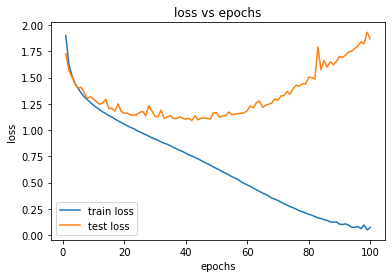

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

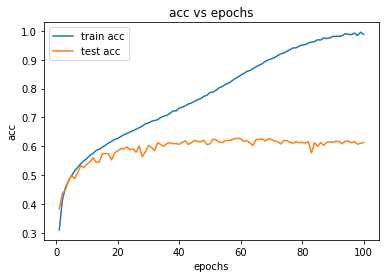

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()